<a href="https://colab.research.google.com/github/vinayprabhu/GaitID-2-SquatID/blob/master/Gait2Squat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1: Let's begin with the imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# from google.colab import drive
# drive.mount('/gdrive')
import warnings
warnings.filterwarnings('ignore')

2: Load the dataset

In [3]:
X_acc=np.load('X_acc_100.npy')
y_user=np.load('y_acc_100.npy')
print(X_acc.shape,y_user.shape)

(587, 4, 100) (587,)


2B: Visualize the dataset:

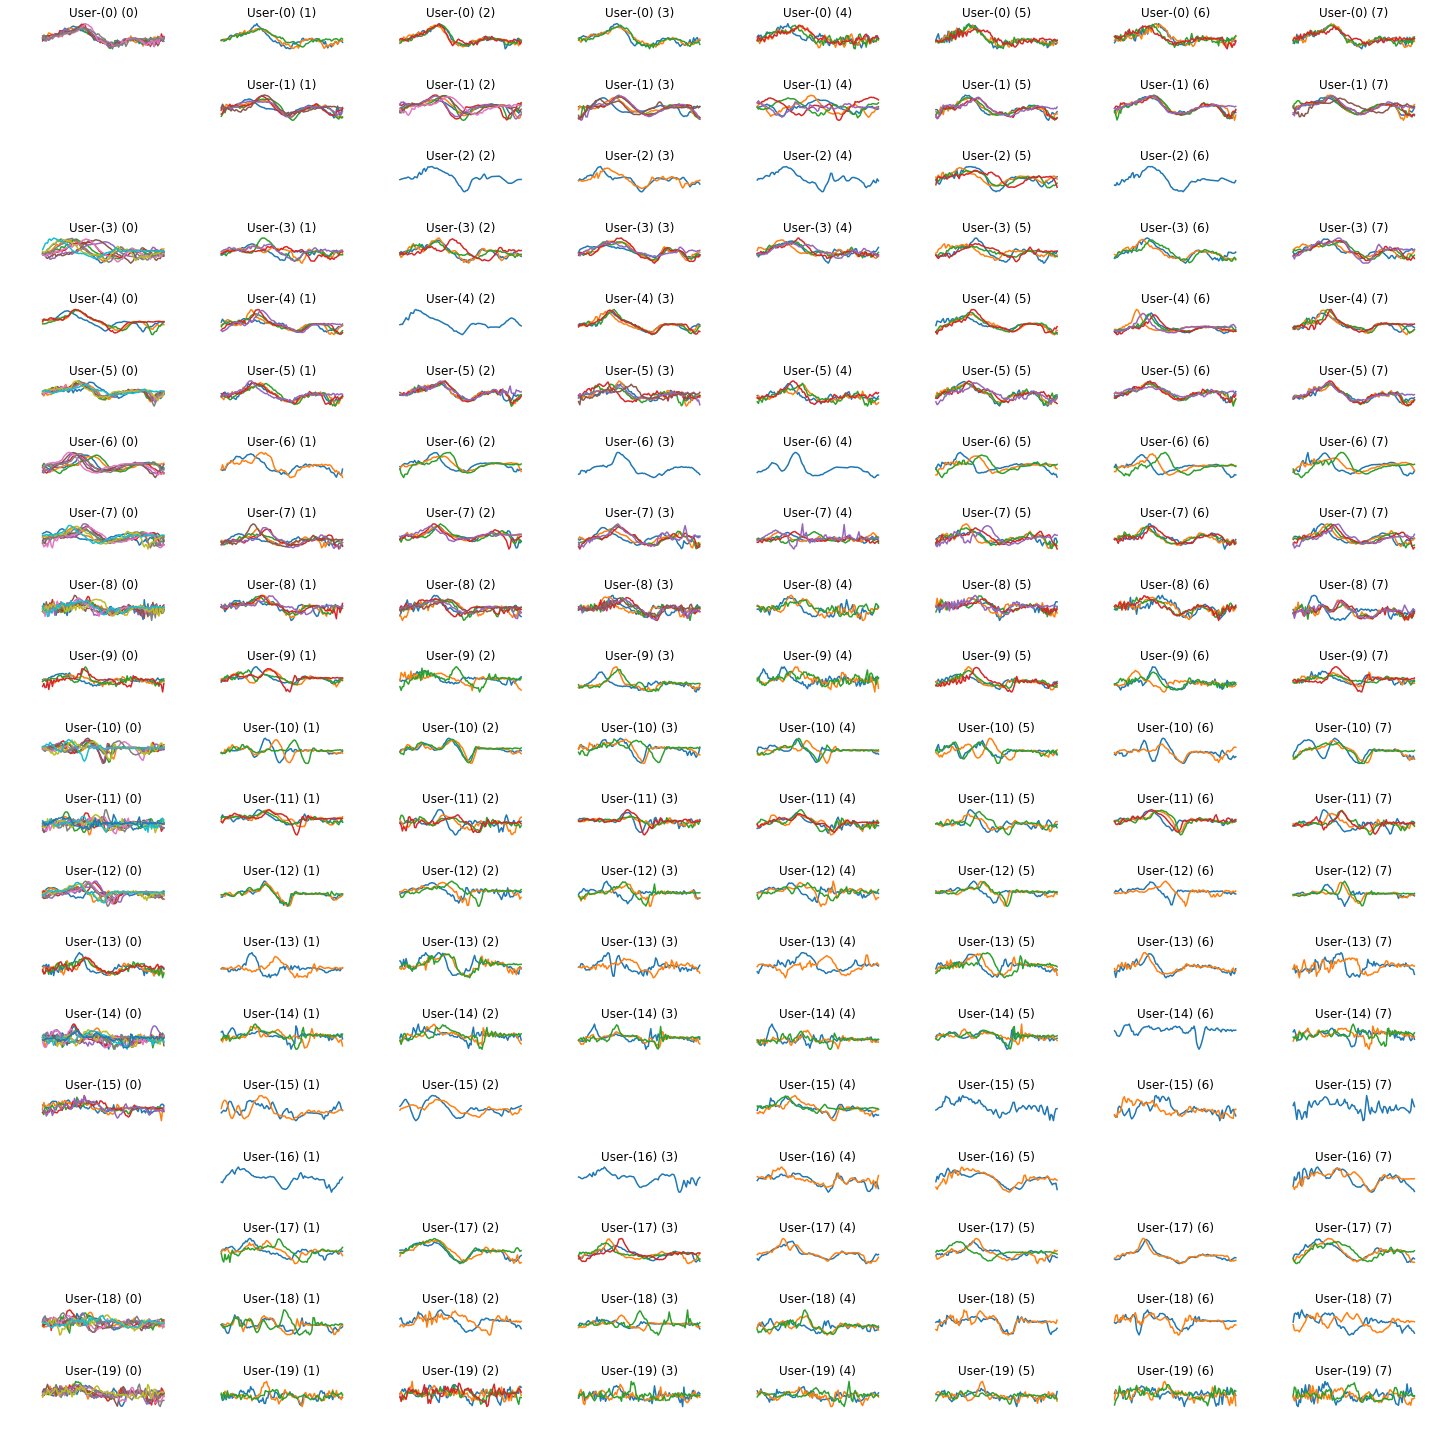

In [4]:
y_squat=np.load('type_labels.npy')

#####################################
plt.figure(figsize=(20,20))
c=0

for u in range(y_user.max()+1):

  for s in range(y_squat.max()+1):


    X_user_squat=X_acc[(y_user==u)&(y_squat==s)]
    c+=1
    if(X_user_squat.shape[0]>0):
      
      plt.subplot(20,8,c)
      plt.plot(X_user_squat[:,3,:].T);
      plt.title(f'User-({u}) ({s})');
      plt.axis('off')

plt.tight_layout()
plt.savefig('acc_grid.png',dpi=200)

In [5]:
X_user_squat.shape

(3, 4, 100)

3: Load the DeepGaitID model

In [6]:
from keras.models import load_model 
model=load_model('DeepGaitID.h5')
model.summary()


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 64, 4, 89)         832       
_________________________________________________________________
batch_normalization_45 (Batc (None, 64, 4, 89)         356       
_________________________________________________________________
p_re_lu_43 (PReLU)           (None, 64, 4, 89)         22784     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 4, 64)         546880    
_________________________________________________________________
batch_normalization_46 (Batc (None, 64, 4, 64)         256       
_________________________________________________________________
p_re_lu_44 (PReLU)           (None, 64, 4, 64)         16384     
_________________________________________________________________
conv

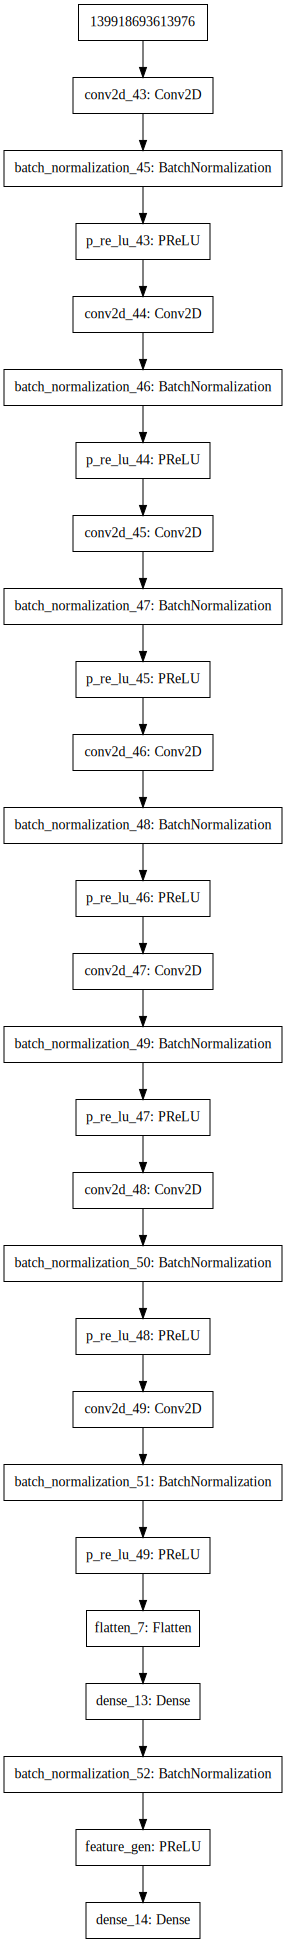

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='DeepGaitID.png')

In [9]:
# Reshape the tensors to be fed into DeepGaitID
# Shape : N_squats x 1 x 4 x 100

X_acc_100=np.expand_dims(X_acc,1)
X_acc_100.shape

(587, 1, 4, 100)

 Do the DeepGaitID features look *separated* enough in the tSNE vizualiation?

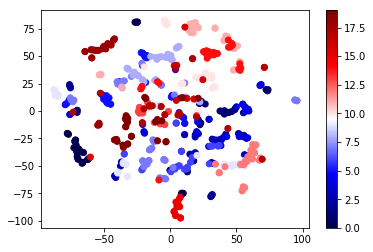

<Figure size 432x288 with 0 Axes>

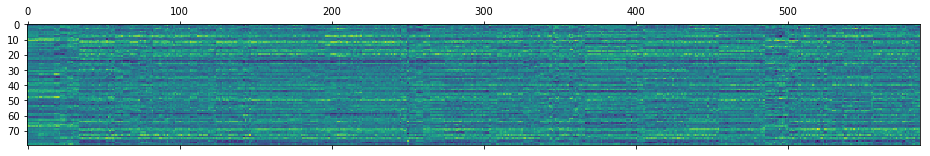

In [10]:
from keras.models import Model
from sklearn.manifold import TSNE as tsne

f_extract = Model(inputs=model.input,
                                 outputs=model.get_layer('feature_gen').output)
F_acc_100 = f_extract.predict(X_acc_100)
F_tsne_2= tsne(n_components=2,perplexity=2.5).fit_transform(F_acc_100)
sc=plt.scatter(F_tsne_2[:,0],F_tsne_2[:,1],c=y_user,cmap='seismic')
plt.colorbar(sc)
plt.figure()
plt.matshow(F_acc_100.T,aspect='auto')

4: Transfer Learning:

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,PReLU
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras import backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
num_classes=y_user.max()+1
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, test_index in sss.split(X_acc_100, y_user):
   x_train, x_test = X_acc_100[train_index], X_acc_100[test_index]
   y_train, y_test = y_user[train_index], y_user[test_index]

print(x_train.shape,x_test.shape)
# convert class vectors to binary class matrices

Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)
batch_size = 8
num_classes = y_user.max()+1
epochs = 50

(352, 1, 4, 100) (235, 1, 4, 100)


In [16]:
from keras.models import load_model 

layer_dict = dict([(layer.name, layer) for layer in model.layers])
x = layer_dict['feature_gen'].output
x = Dense(num_classes, activation='softmax')(x)
from keras.models import Model
custom_model = Model(input=model.input, output=x)
# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_acc', patience=12, verbose=0, mode='max')
mcp_save = ModelCheckpoint('cnn_user-{val_acc:03f}.h5', save_best_only=True, monitor='val_acc', mode='max',verbose=1)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=0, epsilon=1e-4, mode='max')

history=custom_model.fit(x_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
          validation_data=(x_test, Y_test))
score = custom_model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

history_2=custom_model.fit(x_train, Y_train,
          batch_size=64,
          epochs=epochs,
          verbose=1,
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
          validation_data=(x_test, Y_test))
score = custom_model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 352 samples, validate on 235 samples
Epoch 1/50
352/352 [==============================] - 3s 7ms/step - loss: 1.4591 - acc: 0.5994 - val_loss: 1.0478 - val_acc: 0.6851

Epoch 00001: val_acc improved from -inf to 0.68511, saving model to cnn_user-0.685106.h5
Epoch 2/50
352/352 [==============================] - 1s 3ms/step - loss: 0.4473 - acc: 0.8864 - val_loss: 0.8754 - val_acc: 0.7021

Epoch 00002: val_acc improved from 0.68511 to 0.70213, saving model to cnn_user-0.702128.h5
Epoch 3/50
352/352 [==============================] - 1s 3ms/step - loss: 0.2455 - acc: 0.9318 - val_loss: 1.9873 - val_acc: 0.5404

Epoch 00003: val_acc did not improve from 0.70213
Epoch 4/50
352/352 [==============================] - 1s 3ms/step - loss: 0.1912 - acc: 0.9545 - val_loss: 0.4990 - val_acc: 0.8383

Epoch 00004: val_acc improved from 0.70213 to 0.83830, saving model to cnn_user-0.838298.h5
Epoch 5/50
352/352 [==============================] - 1s 3ms/step - loss: 0.1473 - acc: 0.9659 - va

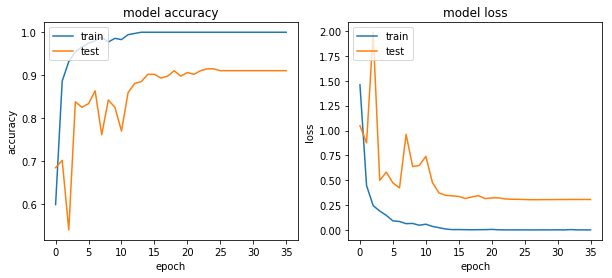

In [17]:
# summarize history for accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('train_test_loss.png',dpi=200)
# plt.show()